In [1]:
import matplotlib.pyplot as plt
import torch

import adsolver
import utils

%load_ext autoreload
%autoreload 2

%matplotlib inline

First, let's just produce a QBO.

36.00 month period


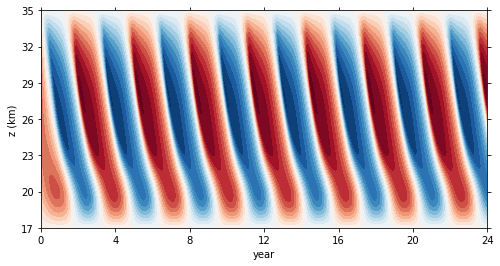

In [75]:
solver = adsolver.ADSolver(
    z_min=17e3, z_max=35e3,
    t_min=0, t_max=(360 * 24 * 86400),
    dz=2.5e2, dt=86400,
    w=0, kappa=3e-1
)

u = solver.solve().numpy()
utils.simple_display(solver.time, solver.z, u.T)

period = utils.estimate_period(solver.time, solver.z, u)
print(f'{period:.2f} month period')